In [ ]:
# download and extract the data.  Only need to do this once.
import zipfile, urllib.request, shutil

url = 'https://code.afcmade.com/afc-ddsd-applicants/summer-fy21/-/raw/master/NLP%20Project/bbc-fulltext.zip'
file_name = 'bbc.zip'

with urllib.request.urlopen(url) as response, open(file_name, 'wb') as out_file:
    shutil.copyfileobj(response, out_file)
    with zipfile.ZipFile(file_name) as zf:
        zf.extractall()

In [ ]:
# data is a folder for each topic and a bunch of text files in each folder
# each text file is the title, followed by the subtitle, followed by the article text
import os
# I want to go into each folder, read each text file into a df and fill these fields: genre, title, subtitle, text
# sourced from https://towardsdatascience.com/transforming-text-files-to-data-tables-with-python-553def411855

# this will read each file
def read_file(genre, file_name):
    text = []
    current_file = os.path.abspath(os.path.join('bbc', genre, file_name))
    if os.path.exists(current_file):
        open_file = open(current_file, 'r', encoding="latin-1")
        text = open_file.read().split('\n')
        text = list(filter(None, text))
    return text

# this will get the files from each genre folder
def extract_genre_files(genre):
    found = True
    current_number = 1
    titles = list()
    subtitles = list()
    texts = list()
    token_counts = list()
    while found:
        file_name = "{:03d}.txt".format(current_number)
        text_data = read_file(genre, file_name)
        if len(text_data) != 0:
            titles.append(text_data[0])
            subtitles.append(text_data[1])
            article_text = ' '.join(text_data[2:])
            texts.append(article_text)
            current_number += 1
        else:
            found = False

    genres = [genre] * len(titles)
    data = {'genre': genres, 'title': titles, 'subtitle': subtitles, 'text': texts}
    data_frame = pd.DataFrame(data)
    return data_frame


In [ ]:
import pandas as pd

# generate the df from the files in the separate folders
def transform_texts_to_df(name, genre_list, delimiter = '\t'):
    article_df_list = list()
    for genre in genre_list:
        article_df_list.append(extract_genre_files(genre))
    df = pd.concat(article_df_list)
    df.to_csv(name, sep=delimiter)
    return df

In [ ]:
# generate the df
if __name__ == "__main__":
    genre_list = ['business', 'entertainment', 'politics', 'sport', 'tech']
    df = transform_texts_to_df('bbc_articles.csv', genre_list)
    print(df.head())

In [ ]:
# write raw text to csv
#df.to_csv('raw_df.csv', encoding='utf-8', index=False)

### Preprocess, split into train, val test

##### Preprocess the text data:
- make lowercase
- remove special characters
- replace contractions
- remove numbers
- remove stopwords
- assumed that mispellings are not a problem (published news articles)
- cut each article down to n words (even lengths)

##### Split into train, validation, and test sets
- by label, separate into train, val and test sets to ensure even-classed data sets
- write to csvs

helper: https://towardsdatascience.com/lstm-text-classification-using-pytorch-2c6c657f8fc0

In [ ]:
import pandas as pd
df = pd.read_csv('raw_df.csv', encoding='utf-8')

In [ ]:
# cut down to even lengths
n_words = 200

def trim(x):
    x = x.split(maxsplit=n_words)
    x = ' '.join(x[:n_words])
    return x

# Remove special characters
import re

def clean_text(x):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', x)
    return text

# Replace contractions
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

contractions, contractions_re = _get_contractions(contraction_dict)

def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)
    
# remove numbers except for single digits
def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x

# title
titles = []
for text in df['title']:
    titles.append(clean_numbers(replace_contractions(clean_text(trim(text).lower()))))

# subtitle
subtitles = []
for text in df['subtitle']:
    subtitles.append(clean_numbers(replace_contractions(clean_text(trim(text).lower()))))  
    
# text
texts = []
for text in df['text']:
    texts.append(clean_numbers(replace_contractions(clean_text(trim(text).lower()))))

In [ ]:
# remove stopwords

# had to install nltk and download stopwords on the remote linux machine:
# conda install -c anaconda nltk
# nltk.download('stopwords')

from nltk.corpus import stopwords
from joblib import Parallel, delayed
import multiprocessing

def remove_stp_wds(doc, stp_wds= stopwords.words('english')):
    filtered_words = []
    for word in doc.split():
        if word.lower() not in stp_wds:
            filtered_words.append(word.lower())
        else:
            next
    return(' '.join(filtered_words)) 

num_cores = multiprocessing.cpu_count()
prep_texts = Parallel(n_jobs=num_cores)(delayed(remove_stp_wds)(doc) for doc in texts)

prep_titles = [remove_stp_wds(doc) for doc in titles]

prep_subtitles = [remove_stp_wds(doc) for doc in subtitles]

In [ ]:
# check first entry of subtitles
prep_subtitles[0]

In [ ]:
# check a preprocessed article
prep_texts[0]

In [ ]:
# concat title, subtitle, and text into titletext
titletext = []
for i in range(len(prep_texts)):
    titletext.append(' '.join([prep_titles[i] , prep_subtitles[i] , prep_texts[i]]))

In [ ]:
# check the first entry
titletext[0]

In [ ]:
# write back to the df, then split by labels
df['x_text'] = prep_texts
df['x_title'] = prep_titles
df['x_subtitle'] = prep_subtitles
df['titletext'] = titletext

# write labels to integers
label = []
for genre in df['genre']:
    if genre == 'business':
       label.append(1)
    elif genre == 'entertainment':
        label.append(2)
    elif genre == 'politics':
        label.append(3)
    elif genre == 'sport':
        label.append(4)
    elif genre == 'tech':
        label.append(5)
df['label'] = label

        
# Split according to label (business, entertainment, politics, sports, tech)
df_business = df.loc[df['label'] == 1, :]
df_entertainment = df.loc[df['label'] == 2, :]
df_politics = df.loc[df['label'] == 3, :]
df_sport = df.loc[df['label'] == 4, :]
df_tech = df.loc[df['label'] == 5, :]

### Ensure that classes are evenly split amoung the train, val, and test sets

In [ ]:
from sklearn.model_selection import train_test_split
train_test_ratio = 0.10
#train_valid_ratio = 0.80

# Train-test split
df_bus_train, df_bus_test = train_test_split(df_business, train_size = train_test_ratio, random_state = 1)
df_ent_train, df_ent_test = train_test_split(df_entertainment, train_size = train_test_ratio, random_state = 1)
df_pol_train, df_pol_test = train_test_split(df_politics, train_size = train_test_ratio, random_state = 1)
df_spo_train, df_spo_test = train_test_split(df_sport, train_size = train_test_ratio, random_state = 1)
df_tec_train, df_tec_test = train_test_split(df_tech, train_size = train_test_ratio, random_state = 1)

# Concatenate splits of different labels
df_train = pd.concat([df_bus_train, df_ent_train, df_pol_train, df_spo_train, df_tec_train], ignore_index=True, sort=False)
#df_valid = pd.concat([df_bus_val, df_ent_val, df_pol_val, df_spo_val, df_tec_val], ignore_index=True, sort=False)
df_test = pd.concat([df_bus_test, df_ent_test, df_pol_test, df_spo_test, df_tec_test], ignore_index=True, sort=False)

# reorder columms
df_train = df_train.loc[:, ['label', 'titletext']]
#df_valid = df_valid.loc[:, ['label', 'titletext']]
df_test = df_test.loc[:, ['label', 'titletext']] 

# Write preprocessed data
df_train.to_csv('train.csv', index=False)
#df_valid.to_csv('valid.csv', index=False)
df_test.to_csv('test.csv', index=False)

## Model development

### Start with processed data...

In [1]:
import pandas as pd
# Read in preprocessed data
df_train=pd.read_csv('train.csv')
#df_valid=pd.read_csv('valid.csv')
df_test=pd.read_csv('test.csv')

In [2]:
set(df_train.label)
df_train.columns

Index(['label', 'titletext'], dtype='object')

In [3]:
# prep data for pytorch implementation
import torch, torchtext
import logging
import io
from torchtext.utils import download_from_url, extract_archive, unicode_csv_reader
from torchtext.data.utils import ngrams_iterator
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.vocab import Vocab
from tqdm import tqdm

# dug into the docs to see how torchtext built-in datasets are loaded.
# these are subsets of the PyTorch Datasets modules
def _csv_iterator(data_path, ngrams, yield_cls=False):
    tokenizer = get_tokenizer("basic_english")
    with io.open(data_path, encoding="utf8") as f:
        next(f)
        reader = unicode_csv_reader(f)
        for row in reader:
            tokens = ' '.join(row[1:])
            tokens = tokenizer(tokens)
            if yield_cls:
                yield int(row[0]) - 1, ngrams_iterator(tokens, ngrams)
            else:
                yield ngrams_iterator(tokens, ngrams)

def _create_data_from_iterator(vocab, iterator, include_unk):
    data = []
    labels = []
    with tqdm(unit_scale=0, unit='lines') as t:
        for cls, tokens in iterator:
            if include_unk:
                tokens = torch.tensor([vocab[token] for token in tokens])
            else:
                token_ids = list(filter(lambda x: x is not Vocab.UNK, [vocab[token]
                                        for token in tokens]))
                tokens = torch.tensor(token_ids)
            if len(tokens) == 0:
                logging.info('Row contains no tokens.')
            data.append((cls, tokens))
            labels.append(cls)
            t.update(1)
    return data, set(labels)                



In [4]:
# generate tensor data from the datasets.  These will be optimized for GPU processing
ngrams = 1

train_csv_path = 'train.csv'

vocab = build_vocab_from_iterator(_csv_iterator(train_csv_path, ngrams))

train_dataset, train_labels = _create_data_from_iterator(
        vocab, _csv_iterator(train_csv_path, ngrams, yield_cls=True), include_unk=True)

test_csv_path = 'test.csv'
test_dataset, test_labels = _create_data_from_iterator(
        vocab, _csv_iterator(test_csv_path, ngrams, yield_cls=True), include_unk=True)

221lines [00:00, 8018.94lines/s]
221lines [00:00, 6533.05lines/s]
2004lines [00:00, 6826.27lines/s]


In [5]:
# From the PyTorch docs on Text Classification
# https://pytorch.org/tutorials/beginner/text_Classifier_ngrams_tutorial.html

In [6]:
# check the processed tensor data
train_dataset[0]

(0,
 tensor([1225, 2443,   17,  954,  214,   50, 1498, 1323,  893,  191, 3045, 3126,
         3464,  954, 1214,    3,  120, 2571,    2,  116,  867,   11,  334, 1795,
         3318,  742,  214, 1225,  259, 1749,  133,  893, 1132,   64, 3045, 3126,
           21, 2501, 5512, 3464, 1852,  893,  954, 1214,   21,  253, 1932,    4,
           29,  989,  979,   26, 1223, 1090,  954, 1214, 1225, 2443,  954,  893,
           45, 1420, 4454, 1422,    3,  120,  116, 2443,  893,   26,  954, 1214,
          487,   11,   23, 2908,  158,  766, 1305,   17,  115,    2, 1225,   74,
          867, 1398,  803, 4192,   81, 6599,  132,  259,   23, 2308, 2019,  141,
         1195, 2445, 1798,  483, 1759,  893, 2657, 7029,  333, 4456, 1225, 2578,
         3956,   24]))

In [15]:
# next seven cells based heavily on the PyTorch docs:
# # https://pytorch.org/tutorials/beginner/text_Classifier_ngrams_tutorial.html

import torch.nn as nn
import torch.nn.functional as F
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [16]:
BATCH_SIZE = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

#VOCAB_SIZE = len(train_dataset.get_vocab())
VOCAB_SIZE = len(vocab)
EMBED_DIM = 100 # ensure this matches pre-trained embeds if using them
#NUN_CLASS = len(train_dataset.get_labels())
NUN_CLASS = len(set([train_dataset[i][0] for i in range(len(train_dataset))]))

cuda


In [17]:
# train embeddings from scratch OR use pre-trained embeddings
# from scratch
model = TextClassifier(VOCAB_SIZE, EMBED_DIM, NUN_CLASS).to(device)

In [18]:
def generate_batch(batch):
    label = torch.tensor([entry[0] for entry in batch])
    text = [entry[1] for entry in batch]
    offsets = [0] + [len(entry) for entry in text]
    # torch.Tensor.cumsum returns the cumulative sum
    # of elements in the dimension dim.
    # torch.Tensor([1.0, 2.0, 3.0]).cumsum(dim=0)

    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text = torch.cat(text)
    return text, offsets, label

In [19]:
from torch.utils.data import DataLoader

def train_func(sub_train_):

    # Train the model
    train_loss = 0
    train_acc = 0
    data = DataLoader(sub_train_, batch_size=BATCH_SIZE, shuffle=True,
                      collate_fn=generate_batch)
    for i, (text, offsets, cls) in enumerate(data):
        optimizer.zero_grad()
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        output = model(text, offsets)
        loss = criterion(output, cls)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_acc += (output.argmax(1) == cls).sum().item()

    # Adjust the learning rate
    scheduler.step()

    return train_loss / len(sub_train_), train_acc / len(sub_train_)

def test(data_):
    loss = 0
    acc = 0
    data = DataLoader(data_, batch_size=BATCH_SIZE, collate_fn=generate_batch)
    for text, offsets, cls in data:
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        with torch.no_grad():
            output = model(text, offsets)
            loss = criterion(output, cls)
            loss += loss.item()
            acc += (output.argmax(1) == cls).sum().item()

    return loss / len(data_), acc / len(data_)

In [20]:
import time
from torch.utils.data.dataset import random_split
N_EPOCHS = 10
min_valid_loss = float('inf')

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=5.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

train_len = int(len(train_dataset) * 0.95)
sub_train_, sub_valid_ = \
    random_split(train_dataset, [train_len, len(train_dataset) - train_len])

for epoch in range(N_EPOCHS):

    start_time = time.time()
    train_loss, train_acc = train_func(sub_train_)
    valid_loss, valid_acc = test(sub_valid_)

    secs = int(time.time() - start_time)
    mins = secs / 60
    secs = secs % 60

    print('Epoch: %d' %(epoch + 1), " | time in %d minutes, %d seconds" %(mins, secs))
    print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
    print(f'\tLoss: {valid_loss:.4f}(valid)\t|\tAcc: {valid_acc * 100:.1f}%(valid)')

Epoch: 1  | time in 0 minutes, 0 seconds
	Loss: 0.4626(train)	|	Acc: 31.6%(train)
	Loss: 0.3761(valid)	|	Acc: 8.3%(valid)
Epoch: 2  | time in 0 minutes, 0 seconds
	Loss: 0.1692(train)	|	Acc: 79.9%(train)
	Loss: 0.1450(valid)	|	Acc: 66.7%(valid)
Epoch: 3  | time in 0 minutes, 0 seconds
	Loss: 0.0375(train)	|	Acc: 99.5%(train)
	Loss: 0.1230(valid)	|	Acc: 91.7%(valid)
Epoch: 4  | time in 0 minutes, 0 seconds
	Loss: 0.0158(train)	|	Acc: 100.0%(train)
	Loss: 0.1268(valid)	|	Acc: 83.3%(valid)
Epoch: 5  | time in 0 minutes, 0 seconds
	Loss: 0.0097(train)	|	Acc: 100.0%(train)
	Loss: 0.1257(valid)	|	Acc: 91.7%(valid)
Epoch: 6  | time in 0 minutes, 0 seconds
	Loss: 0.0063(train)	|	Acc: 100.0%(train)
	Loss: 0.1343(valid)	|	Acc: 91.7%(valid)
Epoch: 7  | time in 0 minutes, 0 seconds
	Loss: 0.0052(train)	|	Acc: 100.0%(train)
	Loss: 0.1324(valid)	|	Acc: 91.7%(valid)
Epoch: 8  | time in 0 minutes, 0 seconds
	Loss: 0.0044(train)	|	Acc: 100.0%(train)
	Loss: 0.1342(valid)	|	Acc: 91.7%(valid)
Epoch: 9  | 

In [21]:
print('Checking the results of test dataset...')
test_loss, test_acc = test(test_dataset)
print(f'\tLoss: {test_loss:.4f}(test)\t|\tAcc: {test_acc * 100:.1f}%(test)')

Checking the results of test dataset...
	Loss: 0.0003(test)	|	Acc: 89.4%(test)


In [22]:
import re
from torchtext.data.utils import ngrams_iterator
from torchtext.data.utils import get_tokenizer

news_label = {1 : "Business",
                 2 : "Entertainment",
                 3 : "Politics",
                 4 : "Sports",
                 5 : "Tech"}

def predict(text, model, vocab, ngrams):
    tokenizer = get_tokenizer("basic_english")
    with torch.no_grad():
        text = torch.tensor([vocab[token]
                            for token in ngrams_iterator(tokenizer(text), ngrams)])
        output = model(text, torch.tensor([0]))
        # return the label - must adjust index returned by argmax by one
        return output.argmax(1).item() + 1

ex_text_str = "MEMPHIS, Tenn. – Four days ago, Jon Rahm was \
    enduring the season’s worst weather conditions on Sunday at The \
    Open on his way to a closing 75 at Royal Portrush, which \
    considering the wind and the rain was a respectable showing. \
    Thursday’s first round at the WGC-FedEx St. Jude Invitational \
    was another story. With temperatures in the mid-80s and hardly any \
    wind, the Spaniard was 13 strokes better in a flawless round. \
    Thanks to his best putting performance on the PGA Tour, Rahm \
    finished with an 8-under 62 for a three-stroke lead, which \
    was even more impressive considering he’d never played the \
    front nine at TPC Southwind."

#vocab = train_dataset.get_vocab()
# put the model on the cpu for predictions
model = model.to("cpu")

print("This is %s news" %news_label[predict(ex_text_str, model, vocab, ngrams)])

This is Tech news


## Check model performance on test set

In [23]:
# run on test set
y_preds = [predict(text, model, vocab, ngrams) for text in df_test.titletext]
test_y = df_test.label

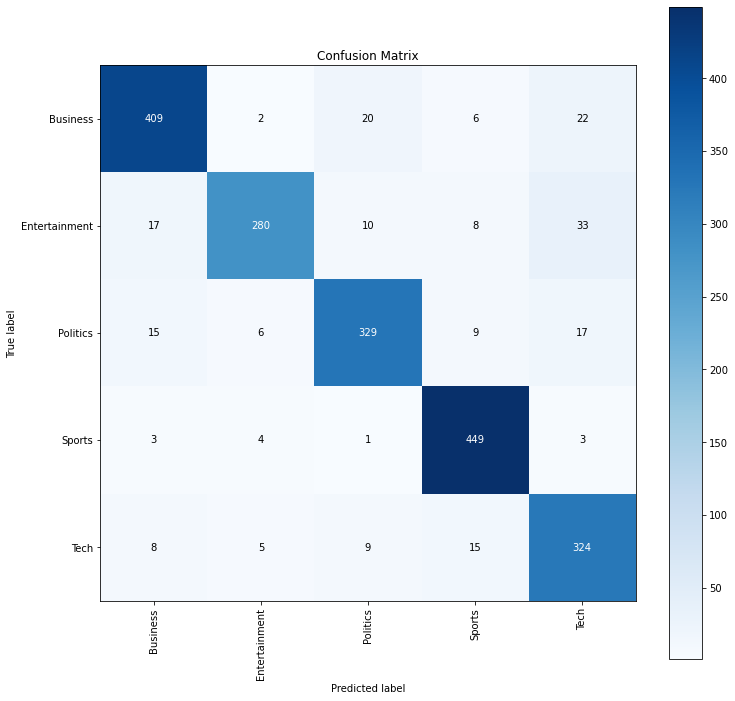

In [24]:
# Check confusion matrix on test set
import scikitplot as skplt
y_true = [news_label[x] for x in test_y]
y_pred = [news_label[x] for x in y_preds]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),
    x_tick_rotation=90)

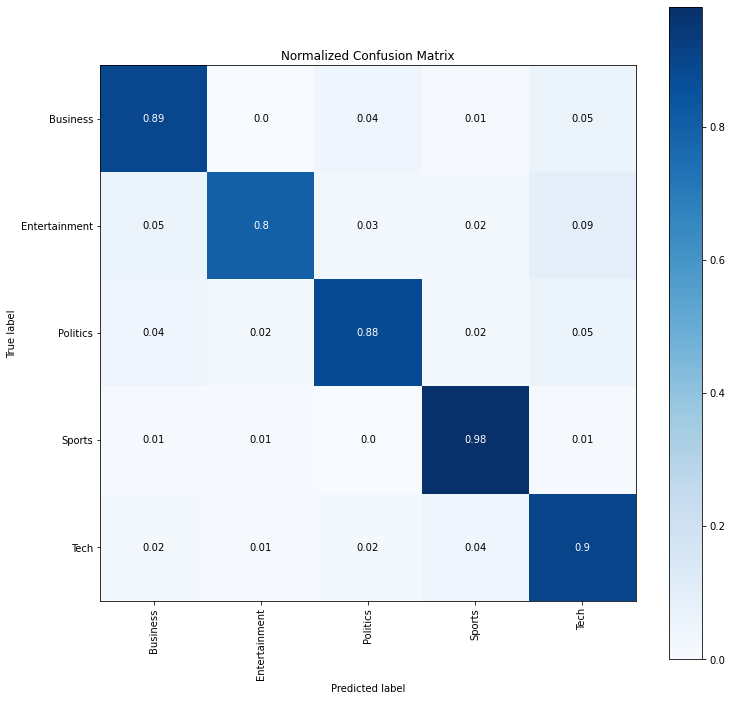

In [25]:
# Check normalized confusion matrix on test set
# The precision metric is the diagonal element / sum of the column
# The recall metric is the diagonal element value
import scikitplot as skplt
import matplotlib.pyplot as plt
y_true = [news_label[x] for x in test_y]
y_pred = [news_label[x] for x in y_preds]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    normalize = True,
    figsize=(12,12),
    x_tick_rotation=90)
plt.savefig('norm_conf_mx.png')

In [28]:
import sklearn
from sklearn.metrics import recall_score, precision_score, f1_score

df_met = pd.DataFrame({'Class' : ["Business", "Entertainment", "Politics",  "Sports", "Tech"],
             'Recall' : sklearn.metrics.recall_score(y_true, y_pred, average = None),
             'Precision' : sklearn.metrics.precision_score(y_true, y_pred, average = None),
             'F1 Score' : sklearn.metrics.f1_score(y_true, y_pred, average = None)})

display(df_met)

#print(df_met.to_html())

,Class,Recall,Precision,F1 Score
0,Business,0.891068,0.904867,0.897914
1,Entertainment,0.804598,0.942761,0.868217
2,Politics,0.875000,0.891599,0.883221
3,Sports,0.976087,0.921971,0.948258
4,Tech,0.897507,0.812030,0.852632


### Analysis of model

##### General 

The model trained to an 89% accuracy on the test set, which is high given the small training data set.  This model does not leverage pretrained embeddings, which would lead me to believe it would need a lot of training examples to generalize well to new samples in the test set.  However, this model performed very well on the test set.  The training time of the model was essentially less than a second per epoch, which is extremely fast. 

##### Performance Metrics 

The confusion matrix is instructive into the model's performance across the classes.  The normalized confusion matrix shows the recall metric as the diagonal value (true positives / true positives + false negatives).  Precision is not directly shown, but is found by the diagonal element divided by the sum of the column values (true positives / true positives + false positives) and is calculated above. Precision and recall give different information about the model performance. For this use case it seems that f1 score, the harmonic mean of precision and recall, is the most important metric for the model.  

Because precision is high and recall is lower for the entertainment class, we can see that the model is under-tagging documents with this label. Therefore, errors for the true-labeled entertainment documents should be examined in more detail. If a class had high recall but suffered from lower precision, the indicates that it was over-tagging articles as being business related. 

Some classes may be more likely to be confused by the model, in this case business.  This is expected because business inherently requires a business sector, which could include tech or sports or entertainment.  Additionally, politics can legislate to regulate business, providing many sources of confusion for the model. 

Intuitively, many news articles will touch on more than one topic and there may be articles that are focused evenly on two or more topics.  I can think of many instances in which a business article would contain many references to entertainment or tech.  It is reasonable that the model would confuse these related classes.  We would not expect there to be much confusion between sports, politics, and tech because there is likely little crossover among these topics in the news.  

##### Error Analysis

Generally, the entertainment class was mislabeled the most.  The highest confused class categories should be explored.  The model made ~10% of its sub-class errors when the model predicted entertainment but the article's true label was tech.

This case (predicted = entertainment, true label = tech) is explored below for demonstration...

In [30]:
# check some of the testing examples that the model got wrong.
# find the index for when the model predicted entertainment but the article was labeled as tech
index = 0
checks = []
for i, j in zip(y_pred, y_true):
    if i == 'Entertainment' and j == 'Tech':
        checks.append(index)
    index += 1

print(checks)

[1763, 1876, 1907, 1916, 1976]


In [31]:
print(df_test.titletext[checks])

1763    ultimate game award doom 3 scifi shooter doom ...
1876    bbc leads interactive bafta wins bbc national ...
1907    halflife 2 sweeps bafta awards pc first person...
1916    ultimate game award doom 3 scifi shooter doom ...
1976    china ripe media explosion asia set drive glob...
Name: titletext, dtype: object


In the case where the model predicted entertainment but the article was labeled as tech, the errors are understandable.  The articles frequently reference a tech product that the company is producing, but also reference the video game, television show, or movie that is affected by the technology.  The model is clearly keying off of words like game, show, or movie but the article is not directly about these things.  

### Save or load the model for future use...

In [29]:
# save out the model
torch.save(model.state_dict(), 'model_v1_89acc.pt')

In [ ]:
# load a previous model

model = TextClassifier()
model.load_state_dict(torch.load('model_v1_89acc.pt'))
model.eval()

In [ ]:
# load on GPU
device = torch.device("cuda")
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH, map_location="cuda:0"))  # Choose whatever GPU device number you want
model.to(device)
# Make sure to call input = input.to(device) on any input tensors that you feed to the model